In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [71]:
df = pd.read_csv('F:/Рабочий стол/AB Test/AB_Test_Results.csv')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [72]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

In [73]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [74]:
df.columns

Index(['USER_ID', 'VARIANT_NAME', 'REVENUE'], dtype='object')

#### Рассмотрим распределение количества уникальных групп для каждого пользователя

In [75]:
double_variant_count = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
double_variant_count

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

In [76]:
# также посмотрим относительно общей суммы
double_variant_count / double_variant_count.sum()

1    0.756325
2    0.243675
Name: VARIANT_NAME, dtype: float64

#### Мы видим, что такие пользователи есть, и их довольно много - 24%. Если вы примете во внимание этих пользователей, то эффект от изменений в эксперименте будет размыт. Поэтому мы исключаем пользовательские данные из расчета изменений в эксперименте

In [77]:
# сначала давайте посмотрим, у каких пользователей есть 1 тестовая группа ab
single_variant_users = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)
# И отберем только этих пользователей
single_variant_users = single_variant_users[single_variant_users]

In [78]:
single_variant_users

USER_ID
2       True
4       True
5       True
6       True
9       True
        ... 
9990    True
9992    True
9993    True
9995    True
9998    True
Name: VARIANT_NAME, Length: 4783, dtype: bool

In [79]:
# оставляйте записи только с пользователями из 1-й тестовой группы ab
df = df[df['USER_ID'].isin(single_variant_users.index)]
# на всякий случай проверьте, соответствует ли количество
# пользователей тому, что было до исключения
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0] == double_variant_count.iloc[0]

True

### Давайте посмотрим, как распределяются данные

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

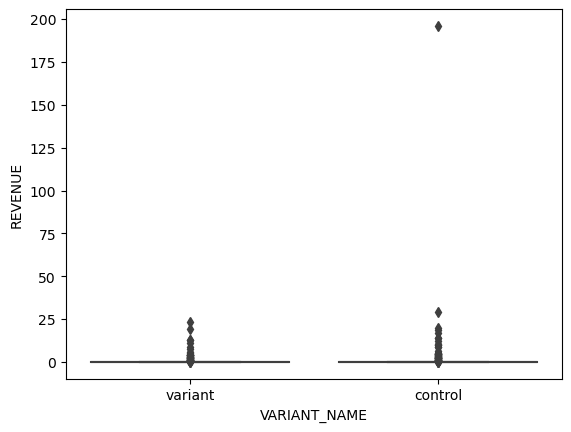

In [80]:
sns.boxplot(data = df, x = 'VARIANT_NAME', y = 'REVENUE')

### Видно, что в данных есть сильный выброс - мы найдем его, отсортировав эти значения выручки в порядке убывания

In [81]:
df.sort_values(by = 'REVENUE', ascending = False).iloc[:10]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56
758,4445,control,17.05
4031,2059,control,14.24
9019,1973,control,14.07
4561,4966,variant,12.99


### Давайте посмотрим, были ли у пользователя 3342 другие события с сильным выбросом

In [82]:
df[df['USER_ID'] == 3342]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


### Мы видим, что есть только один выброс - в условиях ограниченной информации мы удалим эту запись и еще раз посмотрим на распределение данных

In [83]:
df = df[df['USER_ID'] != 3342]

([<matplotlib.axis.XTick at 0x2b14a928880>,
 [Text(0, 0, 'control'), Text(1, 0, 'variant')])

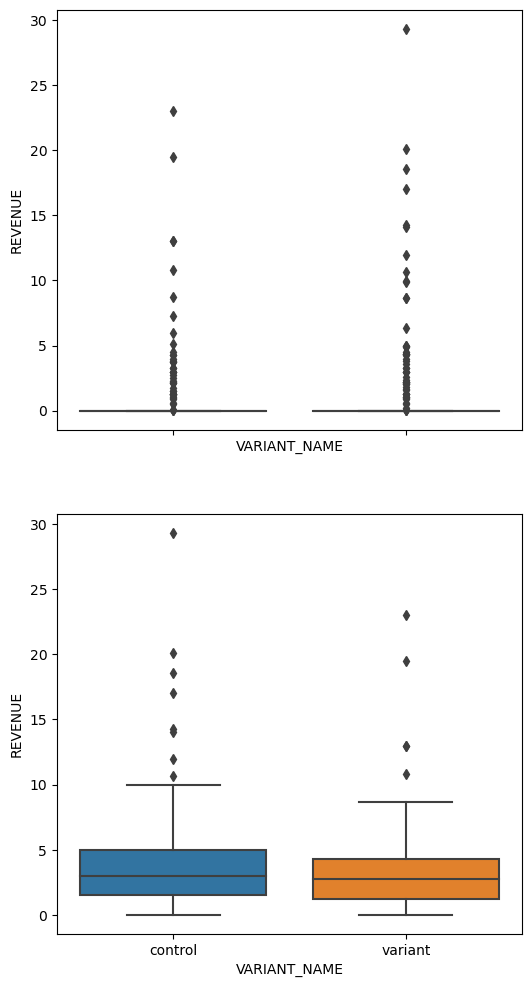

In [84]:
f, axes = plt.subplots(2, sharex = True, figsize = (6,12))
sns.boxplot(ax = axes[0], x = 'VARIANT_NAME', y = 'REVENUE', data = df)
sns.boxplot(data = df[df['REVENUE'] > 0], ax = axes[1], x = 'VARIANT_NAME', y = 'REVENUE')
plt.xticks(np.arange(2), ('control', 'variant'))

Мы видим, что у большинства пользователей нет покупок. Давайте посмотрим, что это за пустые покупки: либо это информация обо всех пользователях, независимо от их действий (даже при отсутствии посещений и положительных покупок), либо эти записи проставляются в случае входа без покупок и могут быть другие записи с положительным доходом.

In [85]:
# давайте посмотрим, есть ли пользователи, у которых есть записи с 
# нулевым и положительным доходом
(df.loc[
    (df['REVENUE'] == 0) & (df['USER_ID'].isin(df.loc[df['REVENUE']> 0, 'USER_ID'].values)),
    'USER_ID'
]).count()

52

Один и тот же пользователь действительно может иметь записи как с нулевым, так и с положительным доходом.

Давайте предположим, что записи - это посещения сервиса пользователями, а экспериментальная единица - это пользователи. Затем мы группируем данные для каждого пользователя и суммируем доход для каждого, чтобы получить по одной записи на пользователя

In [86]:
df = df.groupby(by = ['USER_ID', 'VARIANT_NAME']).sum().reset_index()

### Давайте посмотрим на результирующие распределения

([<matplotlib.axis.XTick at 0x2b14a9f8b80>,
 [Text(0, 0, 'control'), Text(1, 0, 'variant')])

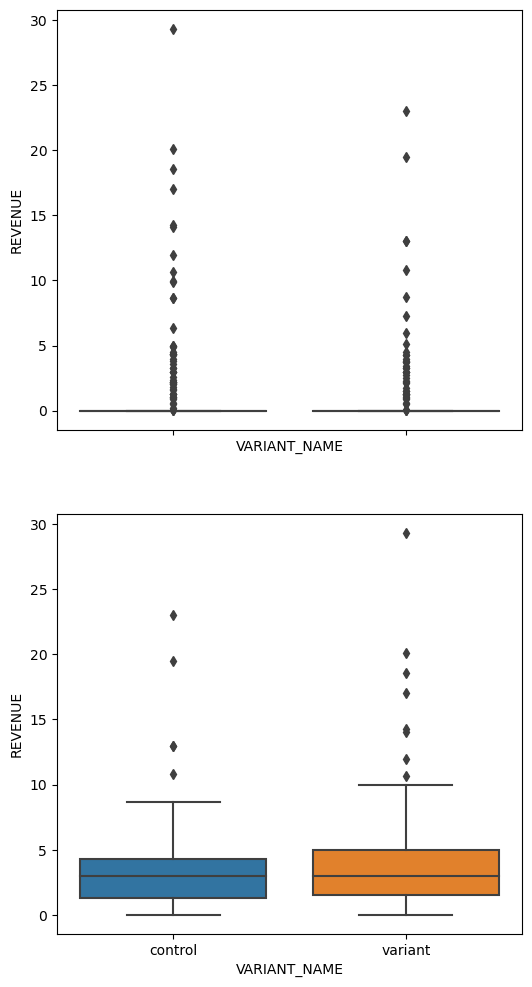

In [87]:
f, axes = plt.subplots(2, sharex = True, figsize = (6,12))
sns.boxplot(data = df, ax = axes[0], x = 'VARIANT_NAME', y = 'REVENUE')
sns.boxplot(data = df[df['REVENUE'] > 0], ax = axes[1], x = 'VARIANT_NAME', y = 'REVENUE')
plt.xticks(np.arange(2), ('control', 'variant'))

Следует отметить, что во время преобразования квантили в тестируемой группе увеличились

Видно, что в тестируемой группе почти все квантильные статистические данные, за исключением минимальных, находятся на несколько более низком уровне.

Давайте рассмотрим различную статистику в контексте тестовых групп AB для всех пользователей

In [88]:
# Расчет метрик по группам
all_stat = df.groupby(by = 'VARIANT_NAME').agg({'USER_ID': 'nunique',
                                               'REVENUE': ['sum', 'mean', 'median', 'count']})

# создадим две дополнительные метрики, чтобы увидеть относительные изменения
orders_per_user = all_stat.loc[:, ('REVENUE', 'count')] / all_stat.loc[: ,('USER_ID', 'nunique')]
revenue_per_user = all_stat.loc[:, ('REVENUE', 'sum')] / all_stat.loc[:, ('USER_ID', 'nunique')]

# добавим их к остальным показателям в отдельной группе
all_stat.loc[:, ('per_user', 'orders')] = orders_per_user
all_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

all_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control         2389  274.55  0.114923    0.0  2389      1.0  0.114923
variant         2393  179.32  0.074935    0.0  2393      1.0  0.074935

Мы видим, что в тестовой группе общая сумма выручки и средний чек на одного пользователя снизились, но количество заказов на одного пользователя немного увеличилось.

Давайте также посмотрим, как ведут себя платящие пользователи

In [89]:
paid_stat = df.loc[df.REVENUE != 0].groupby(by ='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                                                    'REVENUE': ['sum', 'mean', 'median', 'count']})

# добавим две дополнительные метрики, чтобы увидеть относительные изменения
orders_per_user = paid_stat.loc[:, ('REVENUE', 'count')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = paid_stat.loc[:, ('REVENUE', 'sum')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
paid_stat.loc[:, ('per_user', 'orders')] = orders_per_user
paid_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

paid_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control           53  274.55  5.180189   2.99    53      1.0  5.180189
variant           42  179.32  4.269524   2.97    42      1.0  4.269524

### Давайте посмотрим на распределение всех и только платящих пользователей

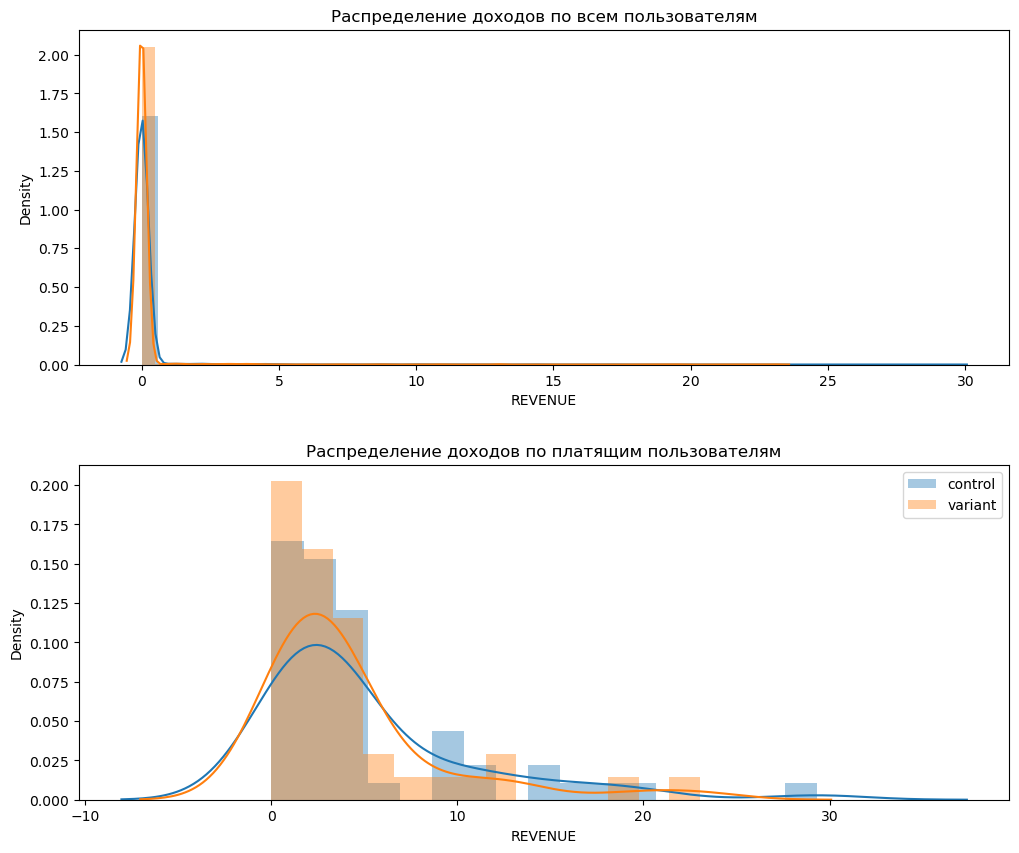

In [90]:
f, axes = plt.subplots(2, figsize = (12, 10))
# постройте графики распределения всех пользователей
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label = 'control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label = 'variant')
axes[0].set_title('Распределение доходов по всем пользователям')

# Построим график распредления платящих пользователей
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label = 'control')
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label = 'variant')
axes[1].set_title('Распределение доходов по платящим пользователям')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

# Статистический анализ

## Проверка на нормальность распределения

Основываясь на их предыдущем графике, мы видим, что данные распределены ненормально, но на всякий случай мы можем подтвердить это формально, используя критерий Шапиро-Уилка

H0 - Данные распределены нормально

H1 - Данные распределены ненормально

In [91]:
shapiro(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'])

ShapiroResult(statistic=0.06145977973937988, pvalue=0.0)

Нулевая гипотеза о нормальном распределении данных отвергается

### Тест Манна-Уитни

Давайте проверим значение статистики теста Манна-Уитни. Некоторые источники имеют ограничение применимости в случае дублирования данных. В нашей выборке много повторений, и особенно много нулевых значений, поэтому в данном случае нам нужно быть осторожными с этим критерием.

In [92]:
(df['REVENUE'] == 0).value_counts()

True     4687
False      95
Name: REVENUE, dtype: int64

Давайте сначала проверим данные всех пользователей

In [93]:
mannwhitneyu(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'], df.loc[df.VARIANT_NAME == 'control', 'REVENUE'])

MannwhitneyuResult(statistic=2845109.0, pvalue=0.24799555106821947)

Только для платящих

In [94]:
mannwhitneyu(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'], 
             df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'])

MannwhitneyuResult(statistic=1029.0, pvalue=0.5314192217084708)

### Bootstrap

Чтобы получить более полную информацию о различиях между средними значениями тестовых групп ab, мы будем использовать bootstap.

Давайте создадим функцию для возврата выборок и получения доверительного интервала, а затем посмотрим на статистику выборок

In [95]:
def get_bootstrap_samples(data, n_samples = 1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

Давайте сгенерируем образцы для всех пользователей

In [96]:
control = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'].values, 10000)
variant = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'].values, 10000)

И только для платящих пользователей

In [97]:
control_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'].values, 10000)
variant_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'].values, 10000)

Давайте посмотрим на распределение средних значений в тестовых группах ab

Text(0.5, 1.0, 'Выборочное среднее распределение для всех пользователей')

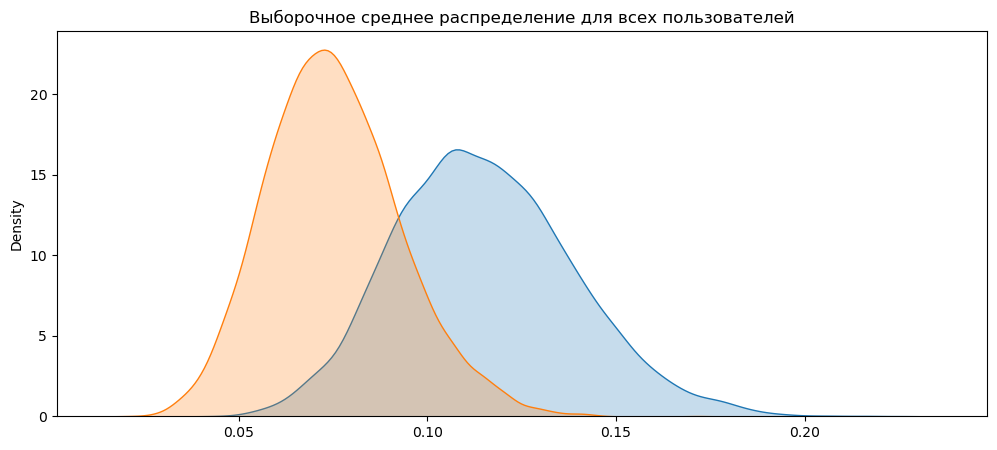

In [98]:
plt.figure(figsize = (12,5))
sns.kdeplot(np.mean(control, axis = 1), shade = True, label = 'control')
sns.kdeplot(np.mean(variant, axis = 1), shade = True, label = 'variant')
plt.title('Выборочное среднее распределение для всех пользователей')

Text(0.5, 1.0, 'Распределение средних для платящих пользователей')

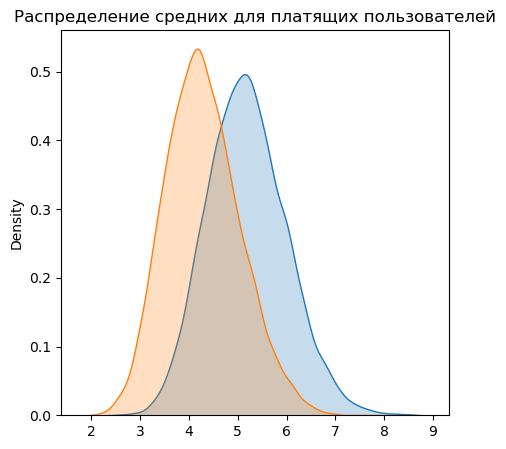

In [99]:
plt.figure(figsize = (5,5))
sns.kdeplot(np.mean(control_paid, axis = 1), shade = True, label = 'control')
sns.kdeplot(np.mean(variant_paid, axis = 1), shade = True, label = 'variant')
plt.title('Распределение средних для платящих пользователей')

Мы видим, что различия есть, но доверительные интервалы могут перекрываться, поэтому вам нужно посмотреть на распределение разницы в средних значениях между группами, чтобы сделать окончательные выводы.

Давайте оценим разницу между группами: посмотрим на распределение средней разницы и построим для нее доверительные интервалы. Для этого мы создадим функцию для визуализации

In [100]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha = 0.05):
#Постройте график распределения средней разности и верните
#доверительные интервалы

    f, ax = plt.subplots()
    # получить данные для раскрашивания доверительных интервалов
    points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    #выделите нулевое значение и границы доверительного интервала
    plt.vlines(0, 0, ymax, label = '0', color = 'gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles = 'dashed')
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles = 'dashed')
    # раскрасьте доверительный интервал и зоны за его пределами
    plt.fill_between(x,y,
                    where = (x >= stat_intervals(variant - control, alpha)[1]),
                    color = 'gainsboro')
    plt.fill_between(x,y,
                    where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color = 'gainsboro')
    plt.fill_between(x,y,
                    where = ((x >= stat_intervals(variant - control, alpha)[0])
                            & (x <=stat_intervals(variant - control, alpha)[1])),
                    color = 'red',
                    label = '95% доверительный интервал')
    plt.title(f'Распределение разницы между средними значениями (variant - control) {title}; {100*(1-alpha)}% Доверительный интервал для разницы средних: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop = {'size':13})
    # возвращает данные доверительного интервала
    return stat_intervals(variant - control)

Давайте построим график распределения разницы в средних и получим доверительный интервал

Для всех пользователей

IndexError: list index out of range

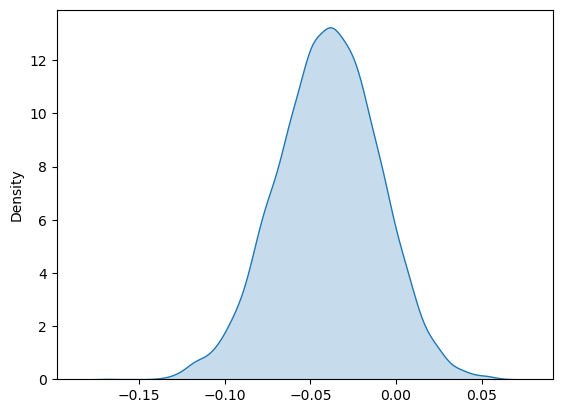

In [101]:
plot_distribution_and_stat_intervals(np.mean(variant, axis=1), 
                                      np.mean(control, axis=1),
                                      title='all users')

IndexError: list index out of range

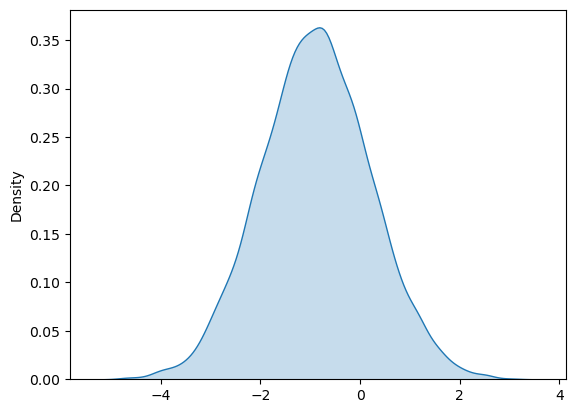

In [102]:
plot_distribution_and_stat_intervals(np.mean(variant_paid, axis = 1),
                                    np.mean(control_paid, axis = 1),
                                    title = 'paying users')

Мы видим, что нулевое значение находится в пределах доверительного интервала, поэтому мы не можем сказать о статистике. 

Значительное изменение среднего дохода между группами тестирования ab

### Итоги

Чтобы сделать выводы об изменениях между группами тестирования ab, сначала в данные были внесены следующие изменения:

Пользователи с двумя тестовыми группами ab были исключены, чтобы сделать эффект изменений более выраженным. 

User_id=3342 был исключен, поскольку в условиях ограниченной информации это является сильным выбросом в полученной выборке.

Пользователи берутся в качестве экспериментальной единицы, а затем данные группируются по каждому пользователю и доходу и суммируется по каждой, чтобы получить по одной записи на пользователя

Несмотря на то, что доход в тестовой группе значительно снизился, статистически значимых изменений между тестовыми группами ab не наблюдалось, как среди всех пользователей, так и только среди платящей аудитории. 

Для более глубокого анализа будут полезны данные A/A-теста и дальнейшего изучения силы критериев.